In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/stft-sliced-dataset/Y_1_sliced.npy
/kaggle/input/stft-sliced-dataset/Y_2_sliced.npy
/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X1_STFT_sliced.npy
/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X6_STFT_sliced.npy
/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X4_STFT_sliced.npy
/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X5_STFT_sliced.npy
/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X2_STFT_sliced.npy
/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X3_STFT_sliced.npy


In [2]:
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler


import numpy as np

import pylab as plt
import pandas as pd
import h5py


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
from matplotlib.lines import Line2D
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import datetime
import warnings

2025-05-13 03:39:47.990979: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747107588.489062      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747107588.606716      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def split_dataset(X, Y, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, stratify=False, random_state=42):
    """
    Splits feature (X) and label (Y) datasets into training, validation, and test sets,
    and normalizes the features using StandardScaler.

    Parameters:
        X (array-like): Feature dataset.
        Y (array-like): Labels corresponding to X.
        train_ratio (float): Proportion of the data for training.
        val_ratio (float): Proportion of the data for validation.
        test_ratio (float): Proportion of the data for testing.
        stratify (bool): Whether to stratify the split based on labels.
        random_state (int): Seed for reproducibility.

    Returns:
        tuple: (X_train, X_val, X_test, Y_train, Y_val, Y_test)
    """
    assert train_ratio + val_ratio + test_ratio == 1, "Ratios must sum to 1."

    stratify_labels = Y if stratify else None

    # First, split data into train and temp (val + test)
    X_train, X_temp, Y_train, Y_temp = train_test_split(
        X, Y, test_size=(val_ratio + test_ratio), stratify=stratify_labels, random_state=random_state
    )

    # Determine stratification for second split
    stratify_labels_temp = Y_temp if stratify else None

    # Split temp into validation and test sets
    X_val, X_test, Y_val, Y_test = train_test_split(
        X_temp, Y_temp, test_size=(test_ratio / (val_ratio + test_ratio)), stratify=stratify_labels_temp, random_state=random_state
    )

    # Normalize features using StandardScaler, handling 3D input
    scaler = StandardScaler()
    if X_train.ndim == 3:
        num_samples, time_steps, num_features = X_train.shape

        X_train_reshaped = X_train.reshape(-1, num_features)
        X_val_reshaped = X_val.reshape(-1, num_features)
        X_test_reshaped = X_test.reshape(-1, num_features)

        X_train_scaled = scaler.fit_transform(X_train_reshaped)
        X_val_scaled = scaler.transform(X_val_reshaped)
        X_test_scaled = scaler.transform(X_test_reshaped)

        X_train = X_train_scaled.reshape(num_samples, time_steps, num_features)
        X_val = X_val_scaled.reshape(X_val.shape[0], time_steps, num_features)
        X_test = X_test_scaled.reshape(X_test.shape[0], time_steps, num_features)
    else:
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)
        X_test = scaler.transform(X_test)

    return X_train, X_val, X_test, Y_train, Y_val, Y_test

In [4]:
X1 = np.load("/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X1_STFT_sliced.npy")
X2 = np.load("/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X2_STFT_sliced.npy")
X3 = np.load("/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X3_STFT_sliced.npy")
X4 = np.load("/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X4_STFT_sliced.npy")
X5 = np.load("/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X5_STFT_sliced.npy")
X6 = np.load("/kaggle/input/stft-sliced-dataset/new_skripsi_stft_sliced_data/new_skripsi_stft_sliced_data/X6_STFT_sliced.npy")

# Concatenate sequentially along the first axis
X = np.concatenate([X1, X2, X3, X4, X5, X6], axis=0)

Y1 = np.load("/kaggle/input/stft-sliced-dataset/Y_1_sliced.npy")
Y2 = np.load("/kaggle/input/stft-sliced-dataset/Y_2_sliced.npy")

Y = np.concatenate([Y1, Y2], axis=0)

In [5]:
X.shape

(75348, 3000, 1)

In [6]:
Y.shape

(75348, 3000, 1)

# balance dataset

In [7]:
import numpy as np

# Misalnya X dan Y bentuknya: (75348, 3000, 1)

# Cari indeks dengan setidaknya satu nilai 1 (positif)
pos_indices = np.where(np.any(Y == 1, axis=(1, 2)))[0]

# Cari indeks yang semuanya 0 (negatif)
neg_indices = np.where(np.all(Y == 0, axis=(1, 2)))[0]

# Jumlah sampel minimum untuk disamakan
num_samples = min(len(pos_indices), len(neg_indices))

# Pilih secara acak
pos_sample_indices = np.random.choice(pos_indices, num_samples, replace=False)
neg_sample_indices = np.random.choice(neg_indices, num_samples, replace=False)

# Gabungkan dan acak indeks
balanced_indices = np.concatenate([pos_sample_indices, neg_sample_indices])
np.random.shuffle(balanced_indices)

# Ambil data seimbang
X_balanced = X[balanced_indices]
Y_balanced = Y[balanced_indices]

print(f"Balanced X shape: {X_balanced.shape}")
print(f"Balanced Y shape: {Y_balanced.shape}")


Balanced X shape: (32460, 3000, 1)
Balanced Y shape: (32460, 3000, 1)


In [8]:
X_train, X_val, X_test, Y_train, Y_val, Y_test = split_dataset(X_balanced, Y_balanced, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, stratify=False, random_state=42)

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dropout, LSTM, Bidirectional, Dense, ReLU



# Model Definition
input_shape = (X_train.shape[1], X_train.shape[2])  # (timesteps, features)
lstm_units = 64
dropout_rate = 0.2

model = Sequential([
    # Convolutional feature extraction
    Conv1D(filters=64, kernel_size=5, padding='same', activation='relu', input_shape=input_shape),
    Dropout(dropout_rate),
    ReLU(),

    # LSTM layers
    LSTM(lstm_units, return_sequences=True),
    #ReLU(),
    Dropout(dropout_rate),

    
    Bidirectional(LSTM(32, return_sequences=True)),
    #ReLU(),
    Dropout(dropout_rate),

    LSTM(lstm_units, return_sequences=True),
    #ReLU(),
    Dropout(dropout_rate),

    # Dense layers
    Dense(64),
    ReLU(),

    Dense(1, activation='sigmoid'),
])


# Compile Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1747107626.576639      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747107626.577367      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 3000, 64)            │             384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 3000, 64)            │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 3000, 64)            │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 3000, 64)            │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3000, 64)            │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 3000, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3000, 1)             │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 95,489 (373.00 KB)

 Trainable params: 95,489 (373.00 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
config = model.get_config()
print(config)

{'name': 'sequential', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'layers': [{'module': 'keras.layers', 'class_name': 'InputLayer', 'config': {'batch_shape': (None, 3000, 1), 'dtype': 'float32', 'sparse': False, 'name': 'input_layer'}, 'registered_name': None}, {'module': 'keras.layers', 'class_name': 'Conv1D', 'config': {'name': 'conv1d', 'trainable': True, 'dtype': {'module': 'keras', 'class_name': 'DTypePolicy', 'config': {'name': 'float32'}, 'registered_name': None}, 'filters': 64, 'kernel_size': (5,), 'strides': (1,), 'padding': 'same', 'data_format': 'channels_last', 'dilation_rate': (1,), 'groups': 1, 'activation': 'relu', 'use_bias': True, 'kernel_initializer': {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}, 'bias_initializer': {'module': 'keras.initializers', 'class_name': 'Zeros', 'config': {}, 'registered_name': None},

In [12]:
weights = model.get_weights()
print(weights)


[array([[[-0.1258545 ,  0.01217046, -0.01243821,  0.10656212,
          0.1277609 ,  0.0054412 , -0.02617839, -0.12349503,
          0.09898053,  0.12081017,  0.02901018, -0.12507081,
         -0.0685286 ,  0.06880207,  0.0572708 , -0.10593279,
          0.07822829,  0.05951497,  0.00762954,  0.07442842,
         -0.00494796, -0.13156655,  0.11128893, -0.00790036,
         -0.10664603,  0.0880906 ,  0.09578347,  0.10729259,
         -0.12015776,  0.04424174, -0.11448263,  0.08055542,
          0.07390505,  0.0336349 ,  0.09148191, -0.02348629,
          0.06973353,  0.10205697,  0.0103125 ,  0.03636448,
          0.01097588, -0.04732455,  0.02522874,  0.11333035,
          0.09312432, -0.08381184,  0.02695404, -0.1034109 ,
          0.09464058, -0.08374391, -0.09455318,  0.09362012,
          0.02657039, -0.06006344,  0.09335867, -0.00831035,
         -0.07900081, -0.08703236,  0.06419584,  0.07343173,
         -0.01116581,  0.02345918,  0.07340565, -0.10925529]],

       [[-0.12201352

# Training

In [13]:
from tensorflow.keras.callbacks import Callback, ModelCheckpoint


In [14]:
class PeriodicSaver(tf.keras.callbacks.Callback):
    def __init__(self, interval=10, prefix='model'):
        super().__init__()
        self.interval = interval
        self.prefix = prefix

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.interval == 0:
            filepath = f"{self.prefix}_epoch_{epoch+1}.h5"  # Use .keras if preferred
            self.model.save(filepath)
            print(f"\nSaved model to {filepath}")

In [15]:
class myCallback(tf.keras.callbacks.Callback):
        def on_epoch_end(self, epoch, logs={}):
            if(logs.get('accuracy') >= 0.97 and logs.get('val_accuracy') >= 0.96):
                print("\n Accuracy is more than 97%, stopping...")
                self.model.stop_training = True


In [16]:
class ToleranceAccuracyCallback(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_accuracy', min_delta=1e-4, patience=5):
        super().__init__()
        self.monitor = monitor
        self.min_delta = min_delta
        self.patience = patience
        self.wait = 0
        self.best = None

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        current = logs.get(self.monitor)

        if current is None:
            return

        if self.best is None:
            self.best = current
        elif (current - self.best) < self.min_delta:
            self.wait += 1
            if self.wait >= self.patience:
                print(f"\nEarly stopping: no improvement in {self.monitor} for {self.patience} epochs.")
                self.model.stop_training = True
        else:
            self.best = current
            self.wait = 0


In [17]:
toleranceCallback = ToleranceAccuracyCallback(
    monitor='val_accuracy',
    min_delta=1e-4,
    patience=20
)

In [18]:
customCallback = myCallback()

In [19]:
periodic_saver = PeriodicSaver(interval=10, prefix='stft_model_200')


In [20]:
# Training
epochs = 100
batch_size = 64 

history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1,
    callbacks=[customCallback, toleranceCallback, periodic_saver]
)

Epoch 1/100


I0000 00:00:1747107636.684496     103 cuda_dnn.cc:529] Loaded cuDNN version 90300


356/356 ━━━━━━━━━━━━━━━━━━━━ 132s 344ms/step - accuracy: 0.8830 - loss: 0.3466 - val_accuracy: 0.8837 - val_loss: 0.3185
Epoch 2/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 125s 352ms/step - accuracy: 0.8860 - loss: 0.3093 - val_accuracy: 0.8837 - val_loss: 0.2998
Epoch 3/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 125s 352ms/step - accuracy: 0.8871 - loss: 0.3024 - val_accuracy: 0.8837 - val_loss: 0.3129
Epoch 4/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 125s 352ms/step - accuracy: 0.8874 - loss: 0.3084 - val_accuracy: 0.8837 - val_loss: 0.3209
Epoch 5/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 125s 352ms/step - accuracy: 0.8866 - loss: 0.3083 - val_accuracy: 0.8837 - val_loss: 0.2989
Epoch 6/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 125s 352ms/step - accuracy: 0.8874 - loss: 0.2955 - val_accuracy: 0.8889 - val_loss: 0.2903
Epoch 7/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 125s 352ms/step - accuracy: 0.8918 - loss: 0.2850 - val_accuracy: 0.8824 - val_loss: 0.3629
Epoch 8/100
356/356 ━━━━━━━━━━━━━━━━━━━━ 125s 352ms/step - accuracy: 0.8849 - los

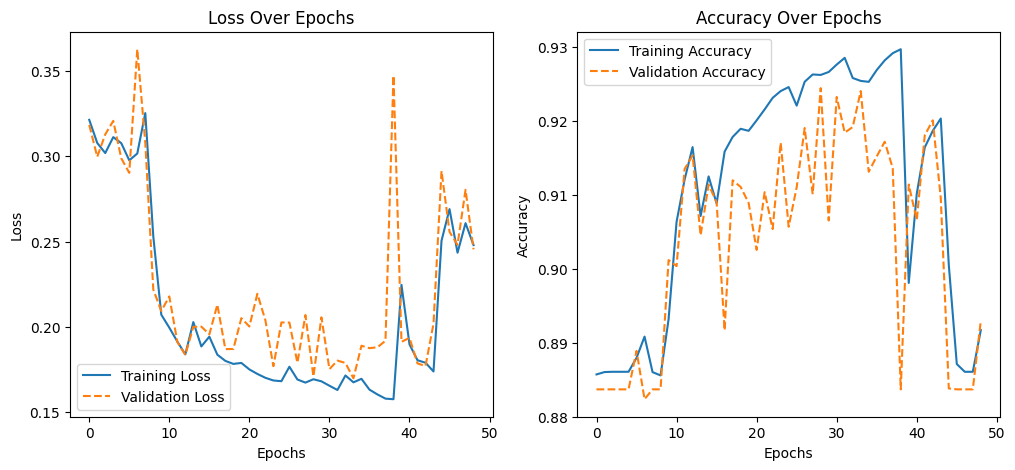

In [21]:
import matplotlib.pyplot as plt

# Extract loss and accuracy from history
loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs_range = range(len(loss))  # Number of epochs

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Over Epochs")
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, accuracy, label="Training Accuracy")
plt.plot(epochs_range, val_accuracy, label="Validation Accuracy", linestyle="dashed")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Over Epochs")
plt.legend()

plt.show()


In [22]:
model.save("stft_200_model.h5")

# Threshold Tuning from Validation

In [23]:
# Get predictions on the validation data
y_pred_val = (model.predict(X_val) > 0.5).astype(int)  # Binarize predictions

153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 123ms/step


In [24]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Flatten the arrays if necessary
y_true_val = Y_val.flatten()  # Flatten true labels to 1D if needed
y_pred_val = y_pred_val.flatten()  # Flatten predicted labels to 1D if needed

# Ensure that both are 1D and binary
print(f"True labels shape: {y_true_val.shape}, Predicted labels shape: {y_pred_val.shape}")

# Calculate Precision, Recall, F1-score
precision = precision_score(y_true_val, y_pred_val)
recall = recall_score(y_true_val, y_pred_val)
f1 = f1_score(y_true_val, y_pred_val)

# Print the scores
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

True labels shape: (14607000,), Predicted labels shape: (14607000,)
Precision: 0.5750
Recall: 0.3057
F1-score: 0.3992


In [25]:
from sklearn.metrics import accuracy_score

# Calculate accuracy
accuracy = accuracy_score(y_true_val, y_pred_val)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.8930


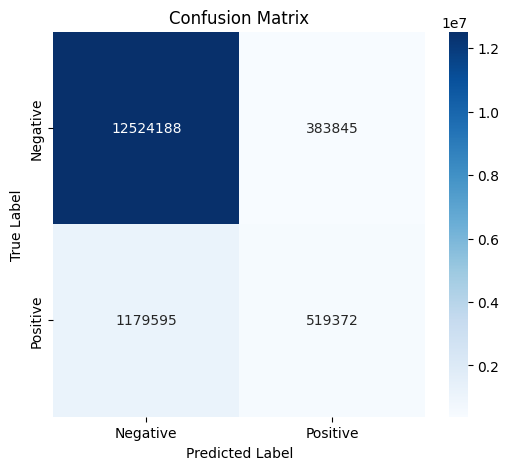

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
# Compute the confusion matrix
cm = confusion_matrix(y_true_val, y_pred_val)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [27]:
threshold = [0.1, 0.2, 0.3, 0.4, 0.5]

In [28]:
for th in threshold:
    # Get predictions on the validation data
    y_pred_val = (model.predict(X_val) > th).astype(int)  # Binarize predictions
    y_true_val = Y_val.flatten()  # Flatten true labels to 1D if needed
    y_pred_val = y_pred_val.flatten()
    #Calculate accuracy
    accuracy = accuracy_score(y_true_val, y_pred_val)
    # Calculate Precision, Recall, F1-score
    precision = precision_score(y_true_val, y_pred_val)
    recall = recall_score(y_true_val, y_pred_val)
    f1 = f1_score(y_true_val, y_pred_val)
    print("\n")
    print(f"Threshold: {th}")
    print(f"Accuracy: {accuracy:.4f}")
    # Print the scores
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-score: {f1:.4f}")
    print("\n")
    
    
    

153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step


Threshold: 0.1
Accuracy: 0.7173
Precision: 0.2840
Recall: 0.9408
F1-score: 0.4363


153/153 ━━━━━━━━━━━━━━━━━━━━ 19s 120ms/step


Threshold: 0.2
Accuracy: 0.7765
Precision: 0.3308
Recall: 0.9007
F1-score: 0.4839


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step


Threshold: 0.3
Accuracy: 0.8111
Precision: 0.3663
Recall: 0.8543
F1-score: 0.5127


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step


Threshold: 0.4
Accuracy: 0.8692
Precision: 0.4584
Recall: 0.6851
F1-score: 0.5493


153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step


Threshold: 0.5
Accuracy: 0.8930
Precision: 0.5750
Recall: 0.3057
F1-score: 0.3992




153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step


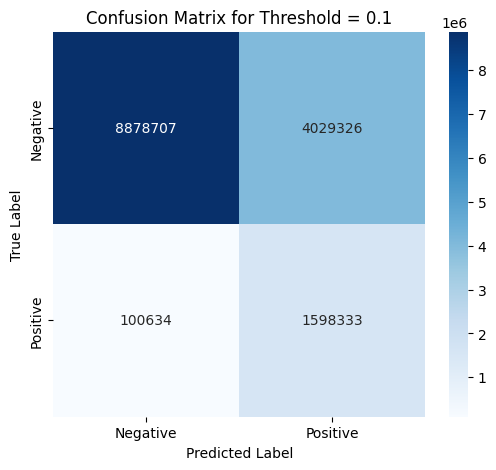

153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 120ms/step


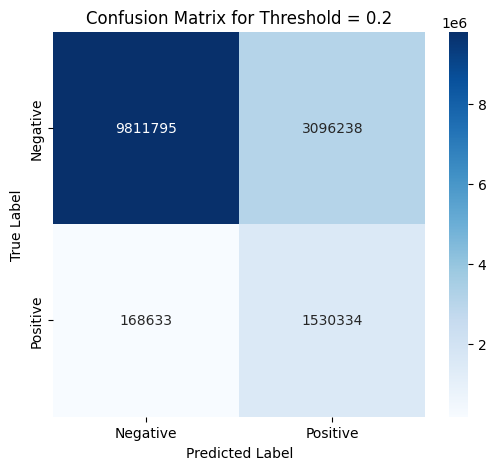

153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step


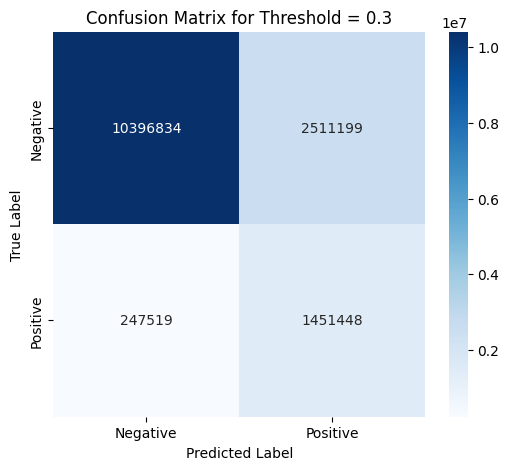

153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step


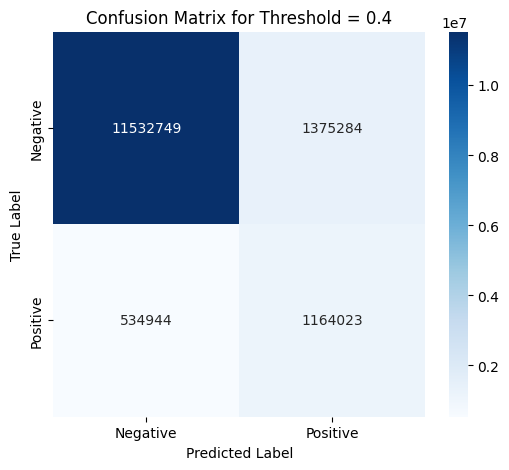

153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step


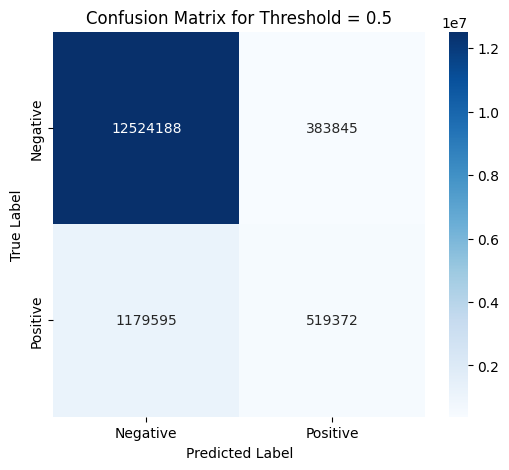

In [29]:
for th in threshold:
    y_pred_val = (model.predict(X_val) > th).astype(int)
    y_true_val = Y_val.flatten()  # Flatten true labels to 1D if needed
    y_pred_val = y_pred_val.flatten()
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true_val, y_pred_val)

    # Plot the confusion matrix using seaborn
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
    plt.title(f"Confusion Matrix for Threshold = {th}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

# model testing with best threshold

In [ ]:
# Get predictions on the validation data
y_pred = (model.predict(X_test) > 0.4).astype(int)  # Binarize predictions

153/153 ━━━━━━━━━━━━━━━━━━━━ 18s 119ms/step


In [44]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Flatten the arrays if necessary
y_true_test = Y_test.flatten()  # Flatten true labels to 1D if needed
y_pred_test = y_pred.flatten()  # Flatten predicted labels to 1D if needed

# Ensure that both are 1D and binary
print(f"True labels shape: {y_true_test.shape}, Predicted labels shape: {y_pred_test.shape}")

accuracy = accuracy_score(y_true_val, y_pred_val)
print(f"Accuracy: {accuracy:.4f}")

# Calculate Precision, Recall, F1-score
precision = precision_score(y_true_test, y_pred_test)
recall = recall_score(y_true_test, y_pred_test)
f1 = f1_score(y_true_test, y_pred_test)

# Print the scores
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

True labels shape: (14607000,), Predicted labels shape: (14607000,)
Accuracy: 0.8930
Precision: 0.5857
Recall: 0.3173
F1-score: 0.4116


In [45]:
import numpy as np

correct_1_indices = []

for i in range(len(Y_test)):
    true_labels = Y_test[i]
    pred_labels = y_pred[i]
    
    # Check if there's any position where both are 1
    if np.any((true_labels == 1) & (pred_labels == 1)):
        correct_1_indices.append(i)

print("Sample indices where model correctly predicted at least one '1':")
print(correct_1_indices)


Sample indices where model correctly predicted at least one '1':
[5, 14, 24, 26, 28, 34, 48, 49, 54, 56, 63, 67, 72, 74, 77, 78, 81, 87, 89, 96, 114, 115, 118, 127, 129, 135, 136, 137, 138, 144, 145, 146, 148, 151, 152, 159, 160, 167, 172, 175, 194, 195, 197, 199, 205, 206, 212, 214, 222, 224, 225, 226, 230, 232, 239, 244, 246, 250, 252, 255, 261, 262, 264, 265, 266, 281, 284, 289, 292, 297, 308, 313, 314, 315, 318, 323, 326, 341, 343, 353, 354, 356, 369, 375, 390, 396, 397, 402, 415, 420, 421, 423, 424, 430, 432, 436, 444, 445, 446, 452, 453, 458, 464, 468, 473, 474, 485, 492, 495, 498, 499, 500, 501, 502, 503, 505, 507, 508, 509, 512, 514, 518, 519, 520, 529, 532, 536, 546, 547, 561, 564, 567, 568, 570, 574, 584, 595, 597, 611, 622, 624, 634, 635, 640, 651, 652, 656, 657, 665, 671, 677, 678, 694, 696, 704, 719, 729, 741, 749, 762, 780, 787, 795, 796, 798, 805, 809, 827, 840, 841, 842, 843, 845, 848, 849, 850, 851, 855, 856, 858, 864, 867, 869, 871, 877, 879, 888, 891, 904, 915, 916, 

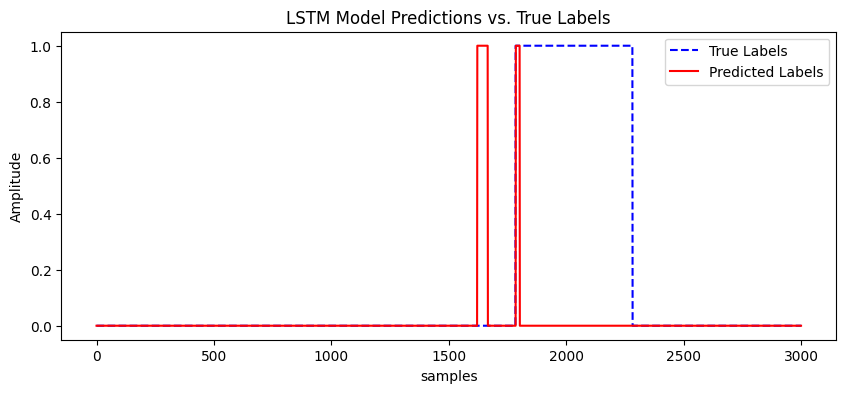

In [56]:
import matplotlib.pyplot as plt

sample_idx = 5# Choose a sample to visualize527
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


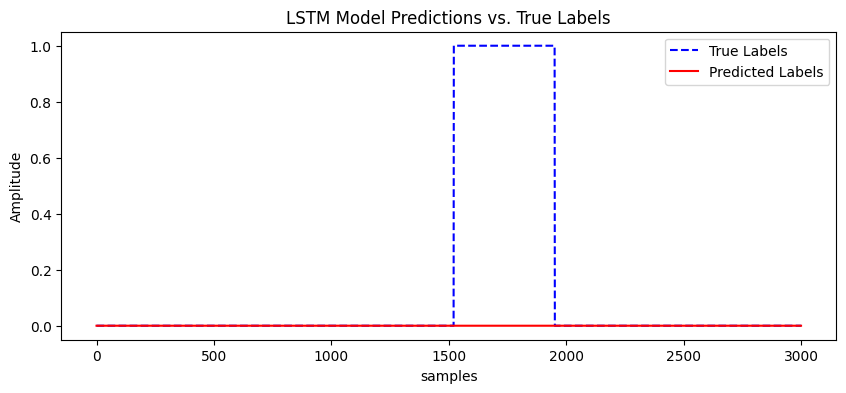

In [47]:
import matplotlib.pyplot as plt

sample_idx = 31# Choose a sample to visualize527
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


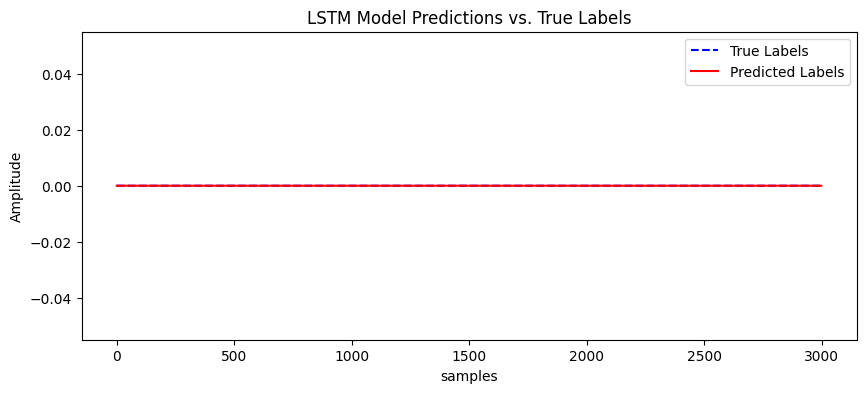

In [48]:
import matplotlib.pyplot as plt

sample_idx = 33# Choose a sample to visualize527
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


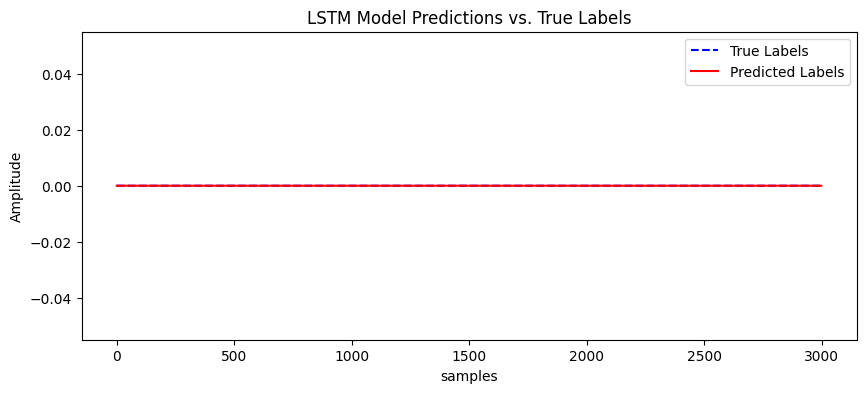

In [49]:
import matplotlib.pyplot as plt

sample_idx = 461# Choose a sample to visualize
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


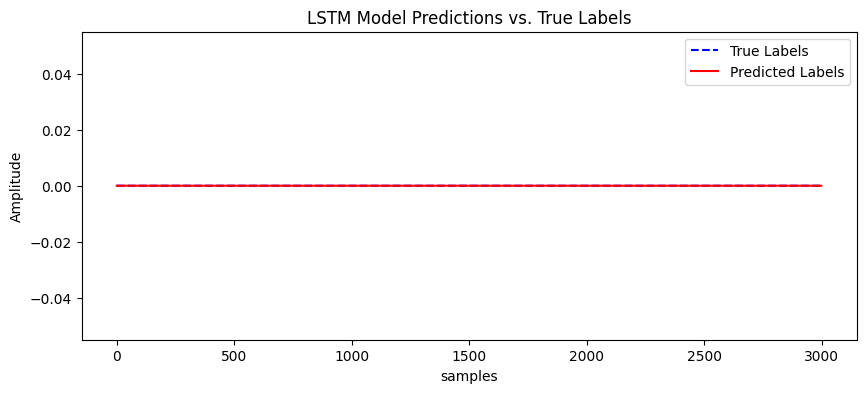

In [50]:
import matplotlib.pyplot as plt

sample_idx = 22# Choose a sample to visualize
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


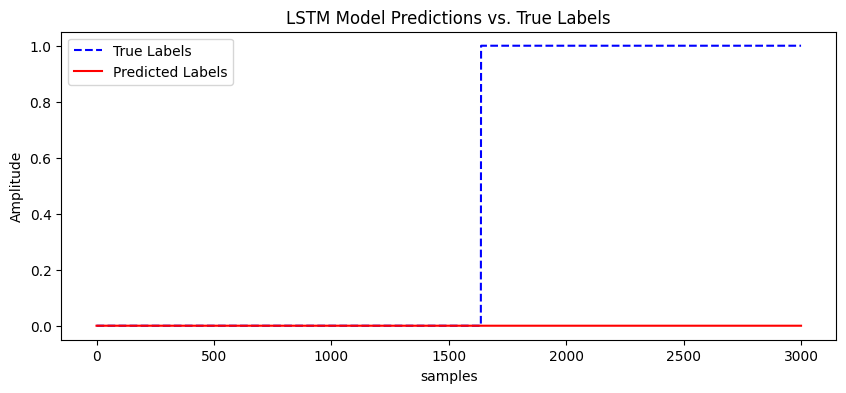

In [51]:
import matplotlib.pyplot as plt

sample_idx = 200# Choose a sample to visualize
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


In [52]:
import numpy as np

correct_1_indices = []

for i in range(len(Y_test)):
    true_labels = Y_test[i]
    pred_labels = y_pred[i]
    
    # Check if there's any position where both are 1
    if np.any((true_labels == 1) & np.all(pred_labels == 0)):
        correct_1_indices.append(i)

print("Sample indices where model correctly predicted at least one '1':")
print(correct_1_indices)


Sample indices where model correctly predicted at least one '1':
[2, 3, 7, 10, 12, 13, 16, 18, 20, 21, 31, 32, 35, 36, 37, 46, 55, 61, 62, 66, 73, 79, 88, 90, 91, 92, 93, 95, 99, 101, 104, 106, 113, 121, 123, 124, 125, 126, 134, 140, 143, 147, 153, 154, 156, 157, 161, 162, 163, 168, 169, 173, 177, 179, 180, 184, 187, 200, 202, 207, 218, 223, 227, 231, 233, 237, 238, 240, 247, 248, 253, 254, 259, 267, 271, 277, 282, 283, 296, 299, 316, 322, 332, 334, 336, 339, 340, 345, 347, 348, 351, 357, 360, 364, 365, 378, 382, 383, 384, 385, 386, 388, 389, 393, 395, 400, 408, 416, 417, 426, 428, 448, 450, 459, 466, 467, 469, 471, 476, 477, 478, 479, 482, 483, 484, 487, 488, 490, 493, 496, 510, 515, 516, 530, 537, 538, 539, 549, 550, 553, 554, 562, 565, 569, 576, 578, 582, 586, 591, 593, 594, 598, 601, 603, 605, 608, 609, 610, 613, 615, 617, 623, 626, 631, 632, 633, 636, 638, 642, 646, 647, 650, 653, 654, 655, 659, 663, 676, 684, 687, 688, 689, 690, 691, 692, 693, 700, 702, 705, 706, 707, 712, 713, 7

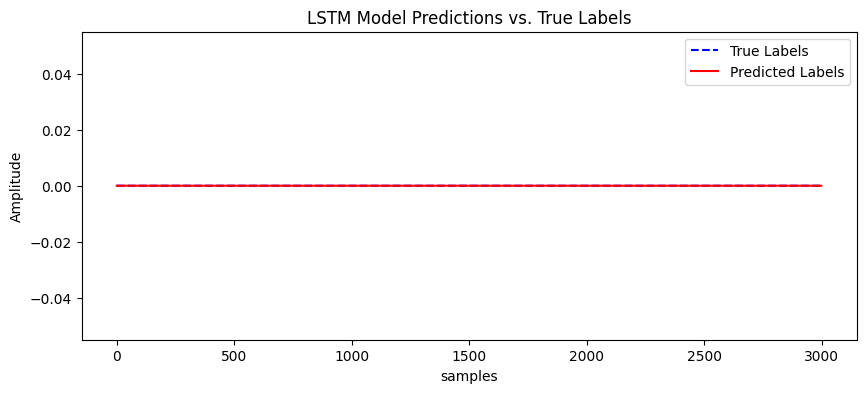

In [53]:
import matplotlib.pyplot as plt

sample_idx = 8# Choose a sample to visualize
plt.figure(figsize=(10, 4))

# Plot true labels
plt.plot(Y_test[sample_idx], label="True Labels", linestyle="dashed", color="blue")
# Plot predicted labels
#plt.plot(Y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.plot(y_pred[sample_idx], label="Predicted Labels", linestyle="solid", color="red")

plt.xlabel("samples")
plt.ylabel("Amplitude")
plt.title("LSTM Model Predictions vs. True Labels")
plt.legend()
plt.show()


# mean onset calculation

In [54]:
import numpy as np

onset_differences = []

for i in range(len(Y_test)):
    true_labels = Y_test[i]
    pred_labels = y_pred[i]
    
    true_indices = np.where(true_labels == 1)[0]
    pred_indices = np.where(pred_labels == 1)[0]
    
    if len(true_indices) > 0 and len(pred_indices) > 0:
        # Compute the difference: predicted - true
        onset_diff = pred_indices[0] - true_indices[0]
        onset_differences.append(onset_diff)

if onset_differences:
    mean_onset_difference = np.mean(onset_differences)
    print("Mean Onset Difference (predicted - true):", mean_onset_difference)
else:
    print("No valid onset pairs found.")


Mean Onset Difference (predicted - true): -84.95205479452055


In [55]:
sampling_rate = 100  # Hz
time_error_seconds = mean_onset_difference / sampling_rate
print("Mean onset error in seconds:", time_error_seconds)

Mean onset error in seconds: -0.8495205479452055
